# AirBnB Big Data

#### This project involves importing data from a csv file called 'listings.csv' and storing it in a MongoDB database. The data is then passed by Spark for data exploration and cleaning. The cleaning process is also done using pandas. Once the data is cleaned, it is cached in a Redis database. Finally, the cleaned data is read from Redis and used to perform price prediction using machine learning.

#### The project likely involves several steps, including importing data, setting up databases, using Spark for data exploration, data cleaning with both Spark and pandas, and implementing a machine learning model for price prediction. The project may be useful for businesses or individuals who need to analyze large amounts of data and make predictions based on that data.

## Prerequisite:
### - redis server running in your local machine in port 6379
### - Install the libraries : pyspark, pandas .... by running the command : 
` pip install -r requirements.txt `
### - the file listings.cvs in the same folder as the notebook

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
import seaborn as sns
import pymongo
import redis
import io
import csv
import time
%matplotlib inline

### MongoDB

In [2]:
# Connect to MongoDB
client = pymongo.MongoClient("mongodb://172.17.0.2:27017/")

# Create database and collection
db = client["airbnb"]
collection = db["listings"]

In [3]:
# # Load data into MongoDB
# airbnb = pd.read_csv('listings.csv')
# data_dict = airbnb.to_dict("records")
# collection.insert_many(data_dict)

#### exploring the data with mongodb

In [4]:
# Get the count of documents in the collection
count = collection.count_documents({})
# Print the count
print(count)

42931


In [5]:
# Find one document
result = collection.find_one()

# Print the result
print(result)

{'_id': ObjectId('6452112fe8f3de2eb7c7ec59'), 'id': 801749842377802394, 'listing_url': 'https://www.airbnb.com/rooms/801749842377802394', 'scrape_id': 20230306014634, 'last_scraped': '2023-03-06', 'source': 'city scrape', 'name': 'A home away from home', 'description': 'The whole group will be comfortable in this spacious and unique space.<br /><br /><b>Guest access</b><br />you can enjoy the living room, dining room, kitchen and the backyard. The home has two entrances', 'neighborhood_overview': nan, 'picture_url': 'https://a0.muscache.com/pictures/miso/Hosting-801749842377802394/original/bf54da63-4a14-4185-a2e2-919a959249bf.jpeg', 'host_id': 495455523, 'host_url': 'https://www.airbnb.com/users/show/495455523', 'host_name': 'Michael', 'host_since': '2023-01-10', 'host_location': nan, 'host_about': nan, 'host_response_time': nan, 'host_response_rate': nan, 'host_acceptance_rate': nan, 'host_is_superhost': 'f', 'host_thumbnail_url': 'https://a0.muscache.com/im/pictures/user/773edbb5-05e

In [6]:
# Retrieve the desired columns
cursor = collection.find({}, {
    "id": 1,
    "name": 1,
    "host_id": 1,
    "host_name": 1,
    "neighbourhood": 1,
    "latitude": 1,
    "longitude": 1,
    "room_type": 1,
    "price": 1,
    "number_of_reviews": 1,
    "beds": 1,
    "bathrooms_text": 1,
    "reviews_per_month": 1,
    "calculated_host_listings_count": 1,
    "availability_365": 1,
    "neighbourhood_group_cleansed": 1,
    "review_scores_rating": 1
})
data = []
# Iterate over the cursor and print the results
for document in cursor:
    data.append(document)
print(data[0])

{'_id': ObjectId('6452112fe8f3de2eb7c7ec59'), 'id': 801749842377802394, 'name': 'A home away from home', 'host_id': 495455523, 'host_name': 'Michael', 'neighbourhood': nan, 'neighbourhood_group_cleansed': 'Brooklyn', 'latitude': 40.64040265671285, 'longitude': -73.88853475272201, 'room_type': 'Private room', 'bathrooms_text': '1 bath', 'beds': 1.0, 'price': '$143.00', 'availability_365': 364, 'number_of_reviews': 0, 'review_scores_rating': nan, 'calculated_host_listings_count': 1, 'reviews_per_month': nan}


In [7]:
#check duplicated values
# Specify the field to check for duplicates
field_to_check = "id"

# Create an index on the field for improved performance
collection.create_index([(field_to_check, pymongo.ASCENDING)], unique=False)

# Find duplicates using an aggregation pipeline
pipeline = [
    {"$group": {"_id": "$" + field_to_check, "count": {"$sum": 1}, "ids": {"$push": "$_id"}}},
    {"$match": {"count": {"$gt": 1}}}
]
duplicates = list(collection.aggregate(pipeline))
len(duplicates)

0

In [8]:
# check null values :
fields = ['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'number_of_reviews', 'beds', 'bathrooms', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'neighbourhood_group_cleansed', 'review_scores_rating']

for field in fields:
    null_documents = collection.find({field: {"$eq": None}})
    print(f'{field}     {len(list(null_documents))}')

id     0
name     0
host_id     0
host_name     0
neighbourhood     0
latitude     0
longitude     0
room_type     0
price     0
number_of_reviews     0
beds     0
bathrooms     0
reviews_per_month     0
calculated_host_listings_count     0
availability_365     0
neighbourhood_group_cleansed     0
review_scores_rating     0


In [9]:
# Get the count of room type

# Define the aggregation pipeline
pipeline = [
    {
        "$group": {
            "_id": "$room_type",
            "count": {"$sum": 1}
        }
    }
]

# Execute the aggregation query
result = list(collection.aggregate(pipeline))

# Print the result
for doc in result:
    print(doc["_id"], doc["count"])

Private room 17879
Hotel room 197
Shared room 576
Entire home/apt 24279


In [10]:
# Get the unique neighborhood values
neighborhoods = collection.distinct("neighbourhood_group_cleansed")

# Print the result
for neighborhood in neighborhoods:
    print(neighborhood)

Bronx
Brooklyn
Manhattan
Queens
Staten Island


#### Parsing the bathroom column

In [11]:
start = time.time()
# Retrieve the "bathroom" column from all documents
bathrooms = [doc['bathrooms_text'] for doc in collection.find({}, {"bathrooms_text": 1})]
l = []
for bath in bathrooms:
    a = str(bath).split(' ')[0]
    if a.isnumeric():
        l.append(float(a))
    else:
        l.append(0.)
bathrooms = l

print('execution time', time.time() - start)

execution time 0.5450038909912109


In [12]:
bathrooms

[1.0,
 1.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 0.0,
 0.0,
 3.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 2.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 2.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 2.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

### Exploring data with Spark

In [13]:
# Create a SparkSession
spark = SparkSession \
    .builder \
    .appName("myApp") \
    .config("spark.mongodb.input.uri", "mongodb://172.17.0.2/airbnb.listings") \
    .config("spark.mongodb.output.uri", "mongodb://172.17.0.2/airbnb.listings") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1') \
    .getOrCreate()

In [14]:
# Load the data from MongoDB into a Spark DataFrame
df = spark.read.format("mongo").load()

In [15]:
print('Data overview')
df.printSchema()

Data overview
root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- accommodates: integer (nullable = true)
 |-- amenities: string (nullable = true)
 |-- availability_30: integer (nullable = true)
 |-- availability_365: integer (nullable = true)
 |-- availability_60: integer (nullable = true)
 |-- availability_90: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- bathrooms_text: string (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- calculated_host_listings_count_entire_homes: integer (nullable = true)
 |-- calculated_host_listings_count_private_rooms: integer (nullable = true)
 |-- calculated_host_listings_count_shared_rooms: integer (nullable = true)
 |-- calendar_last_scraped: string (nullable = true)
 |-- calendar_updated: double (nullable = true)
 |-- description: string (nullable = true)
 |-- first_review: string (n

In [16]:
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,_id,struct<oid:string>
1,accommodates,int
2,amenities,string
3,availability_30,int
4,availability_365,int
...,...,...
71,review_scores_value,double
72,reviews_per_month,double
73,room_type,string
74,scrape_id,bigint


In [17]:

df = df.select(['id', 'name', 'host_id', 'host_name',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
        'number_of_reviews', 'beds', 'bathrooms_text',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'neighbourhood_group_cleansed', 'review_scores_rating'])

In [18]:
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- beds: double (nullable = true)
 |-- bathrooms_text: string (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- availability_365: integer (nullable = true)
 |-- neighbourhood_group_cleansed: string (nullable = true)
 |-- review_scores_rating: double (nullable = true)



In [19]:
from pyspark.sql.functions import count

room_type_counts = df.groupBy('room_type').agg(count('*').alias('count'))
room_type_counts.show()


+---------------+-----+
|      room_type|count|
+---------------+-----+
|    Shared room|  576|
|     Hotel room|  197|
|Entire home/apt|24279|
|   Private room|17879|
+---------------+-----+



In [20]:
unique_neighborhood_group_cleansed = df.select('neighbourhood_group_cleansed').distinct().rdd.flatMap(lambda x: x).collect()
print(unique_neighborhood_group_cleansed)


['Queens', 'Brooklyn', 'Staten Island', 'Manhattan', 'Bronx']


In [21]:
from pyspark.sql.functions import col, sum

null_counts = df.select([sum(col(c).isNull().cast('integer')).alias(c) for c in df.columns])
null_counts.toPandas().to_dict("records")


[{'id': 0,
  'name': 0,
  'host_id': 0,
  'host_name': 0,
  'neighbourhood': 0,
  'latitude': 0,
  'longitude': 0,
  'room_type': 0,
  'price': 0,
  'number_of_reviews': 0,
  'beds': 0,
  'bathrooms_text': 0,
  'reviews_per_month': 0,
  'calculated_host_listings_count': 0,
  'availability_365': 0,
  'neighbourhood_group_cleansed': 0,
  'review_scores_rating': 0}]

In [22]:
from pyspark.sql.functions import isnan, sum

nan_counts = df.select([sum(isnan(c).cast('integer')).alias(c) for c in df.columns])
nan_counts.toPandas().to_dict("records")


[{'id': 0,
  'name': 12,
  'host_id': 0,
  'host_name': 6,
  'neighbourhood': 18060,
  'latitude': 0,
  'longitude': 0,
  'room_type': 0,
  'price': 0,
  'number_of_reviews': 0,
  'beds': 929,
  'bathrooms_text': 75,
  'reviews_per_month': 10304,
  'calculated_host_listings_count': 0,
  'availability_365': 0,
  'neighbourhood_group_cleansed': 0,
  'review_scores_rating': 10304}]

#### Parsing the bathroom column

In [23]:
start = time.time()
from pyspark.sql.functions import regexp_extract, when

df = df.withColumn("bathrooms", when(df["bathrooms_text"].rlike("\\d+"), 
                                          regexp_extract(df["bathrooms_text"], "\\d+", 0))
                                      .otherwise(None))
bath = df.select('bathrooms').toPandas()

print('execution time', time.time() - start)

execution time 1.5088856220245361


In [24]:
bath

,bathrooms
0,1
1,1
2,2
3,2
4,1
...,...
42926,1
42927,1
42928,1
42929,2


### Exploring and cleaning

In [25]:
airbnb = pd.DataFrame(data)

In [26]:
airbnb.dtypes

_id                                object
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood                      object
neighbourhood_group_cleansed       object
latitude                          float64
longitude                         float64
room_type                          object
bathrooms_text                     object
beds                              float64
price                              object
availability_365                    int64
number_of_reviews                   int64
review_scores_rating              float64
calculated_host_listings_count      int64
reviews_per_month                 float64
dtype: object

In [27]:
airbnb['bathrooms'] = bath['bathrooms']

In [28]:
airbnb.drop('bathrooms_text', axis=1, inplace=True)

In [29]:
airbnb.price = airbnb.price.str.replace('$', '').str.replace(',', '').astype(float)

/tmp/ipykernel_3961/1570645803.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  airbnb.price = airbnb.price.str.replace('$', '').str.replace(',', '').astype(float)


In [30]:
airbnb.dtypes

_id                                object
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood                      object
neighbourhood_group_cleansed       object
latitude                          float64
longitude                         float64
room_type                          object
beds                              float64
price                             float64
availability_365                    int64
number_of_reviews                   int64
review_scores_rating              float64
calculated_host_listings_count      int64
reviews_per_month                 float64
bathrooms                          object
dtype: object

In [31]:
airbnb.fillna({'reviews_per_month':0}, inplace=True)
airbnb.fillna({'review_scores_rating':0}, inplace=True)
#examing changes
print(airbnb.reviews_per_month.isnull().sum())
print(airbnb.review_scores_rating.isnull().sum())

0
0


In [32]:
airbnb.describe()

,id,host_id,latitude,longitude,beds,price,availability_365,number_of_reviews,review_scores_rating,calculated_host_listings_count,reviews_per_month
count,4.293100e+04,4.293100e+04,42931.000000,42931.000000,42002.000000,42931.000000,42931.000000,42931.000000,42931.000000,42931.000000,42931.000000
mean,2.222772e+17,1.516012e+08,40.728273,-73.943665,1.656088,200.307167,140.262211,25.856001,3.523633,24.054809,0.888416
std,3.344213e+17,1.621301e+08,0.057640,0.056627,1.170855,895.082911,142.001486,56.616344,2.076931,80.867958,1.638122
min,2.595000e+03,1.678000e+03,40.500314,-74.251907,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.940474e+07,1.608533e+07,40.687485,-73.981750,1.000000,75.000000,0.000000,1.000000,1.000000,1.000000,0.010000
50%,4.337482e+07,7.433812e+07,40.724040,-73.952620,1.000000,125.000000,89.000000,5.000000,4.700000,1.000000,0.240000
75%,6.305016e+17,2.680692e+08,40.762293,-73.924035,2.000000,200.000000,289.000000,24.000000,4.950000,4.000000,1.170000
max,8.404660e+17,5.038729e+08,40.911380,-73.710870,42.000000,99000.000000,365.000000,1842.000000,5.000000,526.000000,86.610000


## Data Visualisation and Exploration:

/tmp/ipykernel_3961/1333293964.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = airbnb.corr(method='kendall')


<Axes: >

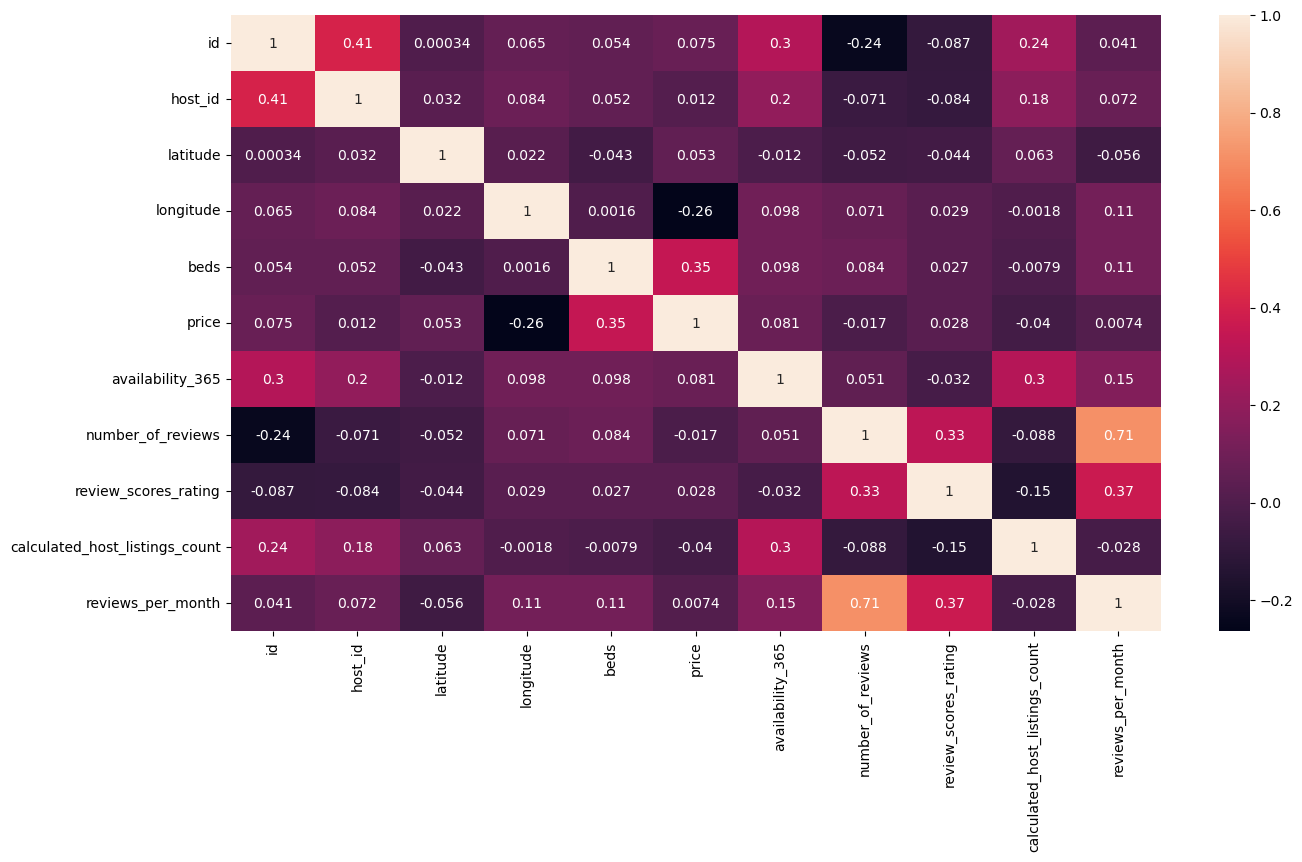

In [33]:
# Correlation
corr = airbnb.corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)

Text(0.5, 1.0, 'Neighbourhood Group')

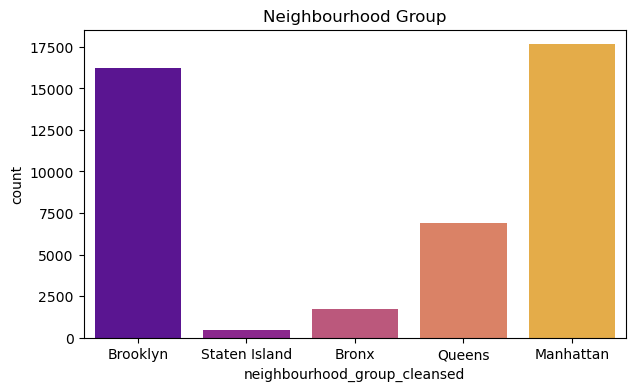

In [34]:
sns.countplot(data=airbnb, x='neighbourhood_group_cleansed', palette="plasma")
fig = plt.gcf()
fig.set_size_inches(7,4)
plt.title('Neighbourhood Group')

Text(0.5, 1.0, 'Room Type')

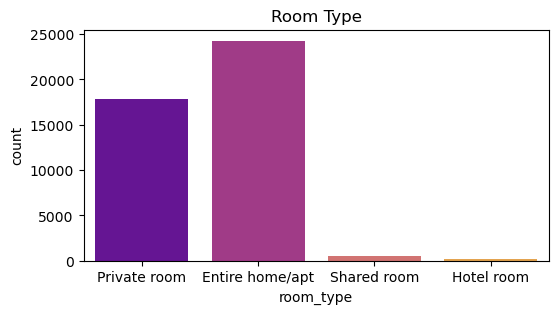

In [35]:
sns.countplot(data=airbnb, x='room_type', palette="plasma")
fig = plt.gcf()
fig.set_size_inches(6,3)
plt.title('Room Type')

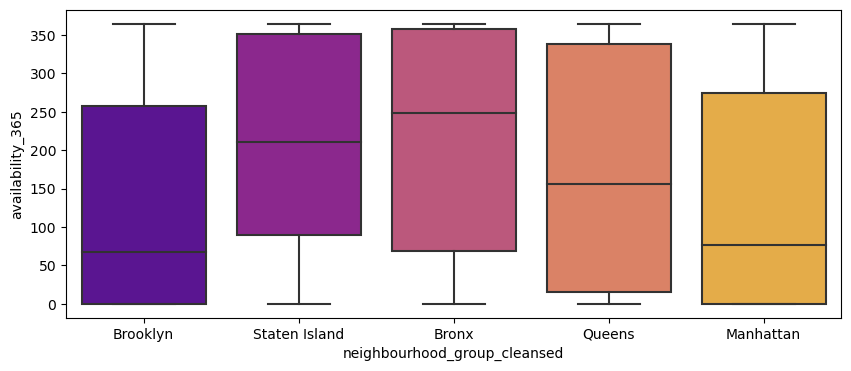

In [36]:
plt.figure(figsize=(10,4))
ax = sns.boxplot(data=airbnb, x='neighbourhood_group_cleansed',y='availability_365',palette='plasma')

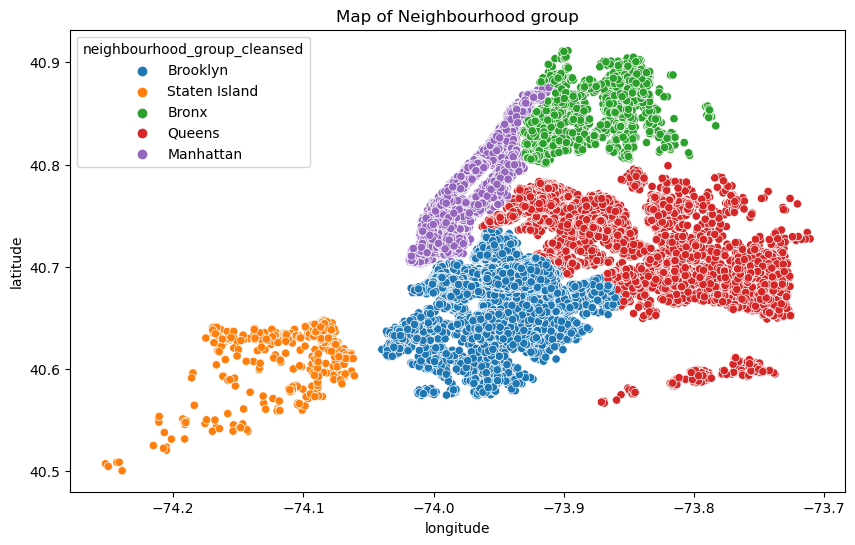

In [37]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=airbnb, x='longitude',y='latitude',hue='neighbourhood_group_cleansed')
plt.title('Map of Neighbourhood group')
plt.show()

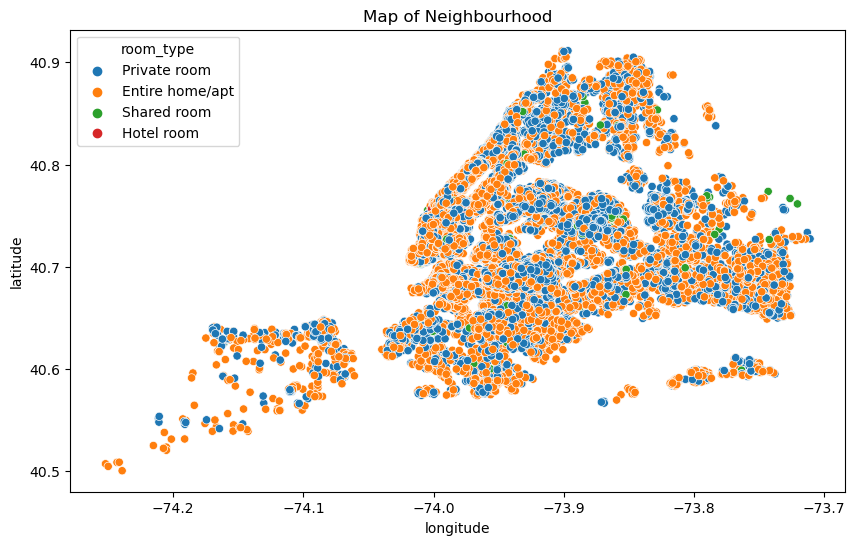

In [38]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=airbnb,  x='longitude',y='latitude', hue='room_type')
plt.title('Map of Neighbourhood')
plt.show()

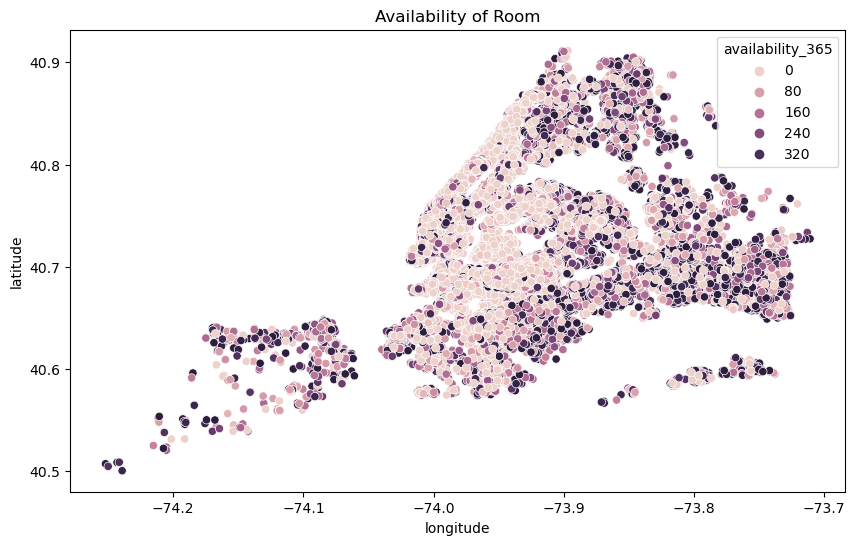

In [39]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=airbnb, x='longitude',y='latitude',hue='availability_365')
plt.title('Availability of Room')
plt.show()

## Caching the data in Redis

In [40]:
# create a Redis client instance
r = redis.Redis(host='172.17.0.3', port=6379, db=0)


In [41]:
# convert the DataFrame to a string using the CSV format
csv_data = airbnb.to_csv(index=False)

# write the string to Redis
r.set('NYC_lis', csv_data)

True

## interacting with redis

In [42]:
# Get all keys in the database
keys = r.keys('*')

# Print the keys
print("Keys in the Redis database:")
for key in keys:
    print(key.decode('utf-8'))

Keys in the Redis database:
fields
NYC_lis


In [43]:
# caching the ield of the data set :
r.set('fields', str(fields))

True

In [44]:
# check the chached data:
f = r.get('fields')
print(f)

b"['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'number_of_reviews', 'beds', 'bathrooms', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'neighbourhood_group_cleansed', 'review_scores_rating']"


In [45]:
redis_data = r.get('NYC_lis')

In [46]:
a = pd.read_csv(io.StringIO(redis_data.decode('utf-8')))

In [47]:
a

,_id,id,name,host_id,host_name,neighbourhood,neighbourhood_group_cleansed,latitude,longitude,room_type,beds,price,availability_365,number_of_reviews,review_scores_rating,calculated_host_listings_count,reviews_per_month,bathrooms
0,6452112fe8f3de2eb7c7ec59,801749842377802394,A home away from home,495455523,Michael,NaN,Brooklyn,40.640403,-73.888535,Private room,1.0,143.0,364,0,0.00,1,0.00,1.0
1,6452112fe8f3de2eb7c7ec5a,765948794133787266,Brooklyn Refuge,488760226,Eric,NaN,Brooklyn,40.648510,-73.894330,Private room,1.0,30.0,41,13,4.85,2,4.29,1.0
2,6452112fe8f3de2eb7c7ec5b,636274456676328779,Villa Masino.,461263600,Tommaso,NaN,Staten Island,40.507114,-74.251907,Entire home/apt,2.0,157.0,364,0,0.00,1,0.00,2.0
3,6452112fe8f3de2eb7c7ec5c,768125251187660469,1-Bedroom Private Room with King Size Bed,475699129,Suliman,NaN,Brooklyn,40.583490,-73.959880,Private room,1.0,89.0,364,15,5.00,7,5.17,2.0
4,6452112fe8f3de2eb7c7ec5d,49248255,Get the best of both worlds in Riverdale!,397288055,Katherine,"The Bronx, New York, United States",Bronx,40.903260,-73.907090,Entire home/apt,2.0,125.0,46,25,4.48,1,1.11,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42926,64521130e8f3de2eb7c89407,40342902,Cozy room in prime area,90429772,Hanna,NaN,Manhattan,40.726110,-73.988010,Private room,1.0,85.0,0,0,0.00,2,0.00,1.0
42927,64521130e8f3de2eb7c89408,35257699,Hell's Kitchen /Times Sq - Comfortable 2 BDR Flat,264962468,Mili,NaN,Manhattan,40.762150,-73.990270,Entire home/apt,3.0,208.0,23,217,4.48,1,4.79,1.0
42928,64521130e8f3de2eb7c89409,52491515,Cozy 3 bedroom apt in the heart of Lower East ...,305489297,Stavros,NaN,Manhattan,40.717330,-73.991110,Entire home/apt,3.0,125.0,191,7,4.43,6,0.43,1.0
42929,64521130e8f3de2eb7c8940a,48158801,Spacious Loft Space / Photo studio in Bushwick,6600525,Quentin,NaN,Brooklyn,40.687350,-73.917660,Private room,1.0,50.0,0,0,0.00,1,0.00,2.0


## Prepare Data For Prediction

In [48]:
# drop the columns that do not affect price
airbnb.drop(['_id', 'id', 'name', 'host_name',  'host_id','neighbourhood'], axis=1, inplace=True)

In [49]:
airbnb.dtypes

neighbourhood_group_cleansed       object
latitude                          float64
longitude                         float64
room_type                          object
beds                              float64
price                             float64
availability_365                    int64
number_of_reviews                   int64
review_scores_rating              float64
calculated_host_listings_count      int64
reviews_per_month                 float64
bathrooms                          object
dtype: object

In [50]:
# Create a new dataframe with one-hot encoded boroughs and room type
boroughs_df = pd.get_dummies(airbnb['neighbourhood_group_cleansed'])
room_type_df = pd.get_dummies(airbnb['room_type'])

# Concatenate the original dataframe with the one-hot encoded boroughs and room type dataframe
airbnb = pd.concat([airbnb, boroughs_df], axis=1)
airbnb = pd.concat([airbnb, room_type_df], axis=1)

# Drop the original 'borough'  and'room_type' columns
airbnb.drop('neighbourhood_group_cleansed', axis=1, inplace=True)
airbnb.drop('room_type', axis=1, inplace=True)
# Print the updated dataframe
airbnb

,latitude,longitude,beds,price,availability_365,number_of_reviews,review_scores_rating,calculated_host_listings_count,reviews_per_month,bathrooms,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Hotel room,Private room,Shared room
0,40.640403,-73.888535,1.0,143.0,364,0,0.00,1,0.00,1,0,1,0,0,0,0,0,1,0
1,40.648510,-73.894330,1.0,30.0,41,13,4.85,2,4.29,1,0,1,0,0,0,0,0,1,0
2,40.507114,-74.251907,2.0,157.0,364,0,0.00,1,0.00,2,0,0,0,0,1,1,0,0,0
3,40.583490,-73.959880,1.0,89.0,364,15,5.00,7,5.17,2,0,1,0,0,0,0,0,1,0
4,40.903260,-73.907090,2.0,125.0,46,25,4.48,1,1.11,1,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42926,40.726110,-73.988010,1.0,85.0,0,0,0.00,2,0.00,1,0,0,1,0,0,0,0,1,0
42927,40.762150,-73.990270,3.0,208.0,23,217,4.48,1,4.79,1,0,0,1,0,0,1,0,0,0
42928,40.717330,-73.991110,3.0,125.0,191,7,4.43,6,0.43,1,0,0,1,0,0,1,0,0,0
42929,40.687350,-73.917660,1.0,50.0,0,0,0.00,1,0.00,2,0,1,0,0,0,0,0,1,0


In [51]:
airbnb.dropna(inplace=True)

In [52]:
airbnb.isnull().sum()

latitude                          0
longitude                         0
beds                              0
price                             0
availability_365                  0
number_of_reviews                 0
review_scores_rating              0
calculated_host_listings_count    0
reviews_per_month                 0
bathrooms                         0
Bronx                             0
Brooklyn                          0
Manhattan                         0
Queens                            0
Staten Island                     0
Entire home/apt                   0
Hotel room                        0
Private room                      0
Shared room                       0
dtype: int64

In [53]:
airbnb.drop(['calculated_host_listings_count'], axis=1, inplace=True)

In [54]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [55]:
#Defining the independent variables and dependent variables
x = airbnb.drop('price', axis=1)
y = airbnb['price']
#Getting Test and Training Set
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25, random_state=40)

In [56]:
models = [
    LinearRegression(),
    Lasso(),
    Ridge()
]


In [57]:
# Loop over each model and evaluate its performance
for model in models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    score=r2_score(y_test, y_pred)
    print('Mean Squared Error:', mse)
    print('R-squared:', score)
    print('--------------------------')

Mean Squared Error: 813598.8776586173
R-squared: 0.024707392831931574
--------------------------
Mean Squared Error: 813135.6993201501
R-squared: 0.025262622714508853
--------------------------
Mean Squared Error: 813572.7548388104
R-squared: 0.024738707271682703
--------------------------
